# CNN
build and train a convolutional neural network (CNN) using the Keras library in Python for image classification tasks. ( CIFAR-10 dataset)

# Data Augmentation
implement data augmentation using the Keras library in Python to improve the performance of a convolutional neural network (CNN) on image classification tasks. ( CIFAR-10 dataset)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import os
import torch.nn.functional as F
import requests
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
torch.manual_seed(1)
from sklearn import preprocessing
from torch.utils.data import DataLoader, Dataset, Subset

# Define GPU device - We will run our model on GPU
cuda_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

In [ ]:
IMAGE_SIZE = 32

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

composed_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image
    transforms.RandomRotation(20),               # Random rotation by up to 20 degrees
    transforms.RandomHorizontalFlip(0.1),        # Horizontal flip with 10% probability
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # Color jitter
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # Adjust sharpness
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean, std),             # Normalize the image tensor
    transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0)  # Random erasing
])


composed_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize the image
    transforms.ToTensor(),                        # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std)               # Normalize the image tensor using the specified mean and std
])

In [ ]:
# Load the data and transform the dataset
train_dataset = dsets.CIFAR10(root = '.data', train = True, download = True, transform = composed_train)
validation_dataset = dsets.CIFAR10(root = './data', train = False, download = True, transform = composed_test)

# Create train and validation batch for training
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 100)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1, 2, 0).shape)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.title('y = ' + str(img[1]))

def im_convert(tensor):
    # Lets
    img = tensor.cpu().clone().detach().numpy()
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1)
    return img

## Print some random data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9577202..2.0906394].


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


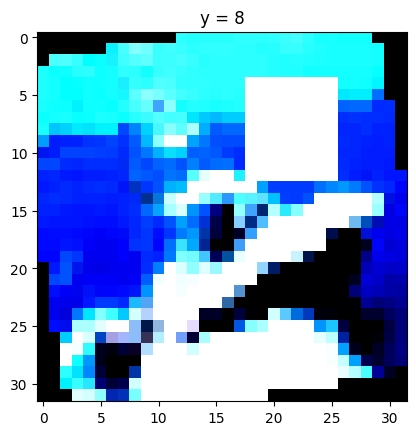

In [ ]:
show_data(train_dataset[8])

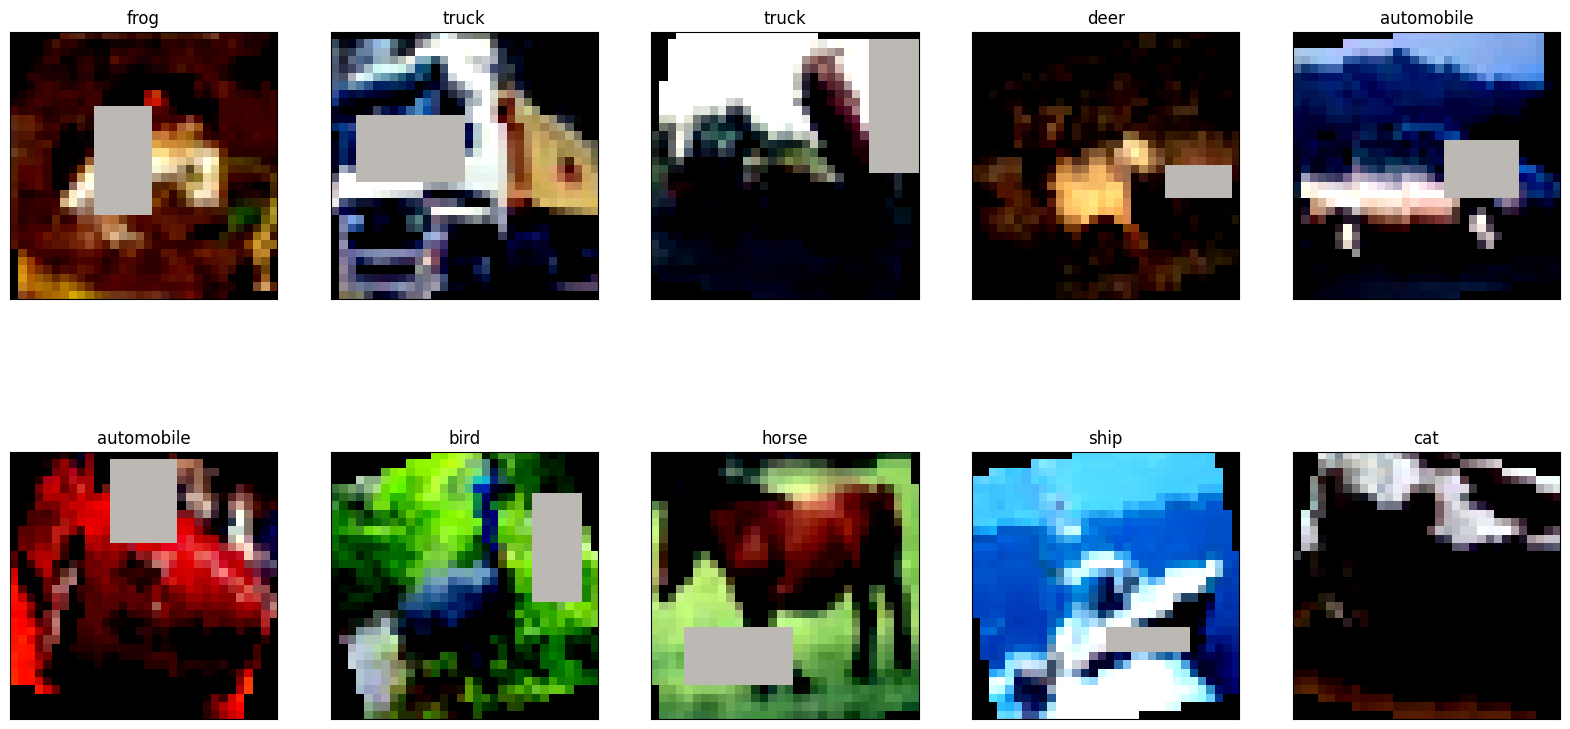

In [ ]:
# Define classes in CIPHAR 10 dataset.
classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')
# Define an iterable on the data
data_iterable = iter(train_loader) # Converting our train_dataloader to iterable so that we can iter thtough it/
images, labels = next(data_iterable) # Going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize = (20, 10))

# Lets plot 50 images from our train_dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx + 1, xticks = [], yticks = [])

    # Convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [ ]:
class CNN_V3_V4(nn.Module):
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p = 0.2)

        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size =5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)

        # Hidden Layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000)
        self.drop = nn.Dropout(p = p)
        self.fc1_bn = nn.BatchNorm1d(1000)

        # Hidden Layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden Layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)

        # Hidden Layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)

        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)

    # Predictions
    def forward(self, x):
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.maxpool1(x)
        x = self.drop_conv(x)

        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop_conv(x)

        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop_conv(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc1_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)

        return x

## Define common model training module

In [ ]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs=20):
    N_test = len(validation_loader.dataset)
    accuracy_list = []
    train_cost_list = []
    val_cost_list = []

    # Move model to the available device
    model = model.to(device)

    for epoch in range(n_epochs):
        train_COST = 0  # Initialize as a float, not a tuple
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criteration(z, y)
            loss.backward()
            optimizer.step()
            train_COST += loss.item()  # Add loss (a float) to train_COST

        train_COST = train_COST / len(train_loader)
        train_cost_list.append(train_COST)  # Fixed method name from "train_cost_list_append"

        correct = 0
        val_COST = 0  # Initialize as a float, not a tuple

        # Validation phase
        with torch.no_grad():
            for x_test, y_test in validation_loader:
                model.eval()
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                z = model(x_test)
                val_loss = criteration(z, y_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
                val_COST += val_loss.item()  # Add val_loss to val_COST

        val_COST = val_COST / len(validation_loader)
        val_cost_list.append(val_COST)

        accuracy = correct / N_test
        accuracy_list.append(accuracy)

        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}" .format(round(train_COST, 4)),
              " | Validation Loss : {}" .format(round(val_COST, 4)),
              " | Validation Accuracy : {}%" .format(round(accuracy * 100, 2)))

    return accuracy_list, train_cost_list, val_cost_list


In [ ]:
model_mmtv5 = CNN_V3_V4(out_1=32, out_2=64, out_3=128, number_of_classes=10, p=0.5)
criteration = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv5.parameters(), lr=learning_rate, momentum=0.2)

# Train the model
accuracy_list_normalv5, train_cost_listv5, val_cost_listv5 = train_model(
    model=model_mmtv5,
    n_epochs=200,
    train_loader=train_loader,
    validation_loader=validation_loader,
    optimizer=optimizer
)


--> Epoch Number : 1  | Training Loss : 1.7136  | Validation Loss : 1.3777  | Validation Accuracy : 49.96%
--> Epoch Number : 2  | Training Loss : 1.4482  | Validation Loss : 1.2356  | Validation Accuracy : 56.07%
--> Epoch Number : 3  | Training Loss : 1.3269  | Validation Loss : 1.0777  | Validation Accuracy : 61.41%
--> Epoch Number : 4  | Training Loss : 1.2471  | Validation Loss : 0.9741  | Validation Accuracy : 65.07%
--> Epoch Number : 5  | Training Loss : 1.1888  | Validation Loss : 0.9065  | Validation Accuracy : 67.86%
--> Epoch Number : 6  | Training Loss : 1.1398  | Validation Loss : 0.8632  | Validation Accuracy : 69.54%
--> Epoch Number : 7  | Training Loss : 1.0972  | Validation Loss : 0.8355  | Validation Accuracy : 70.63%
--> Epoch Number : 8  | Training Loss : 1.0655  | Validation Loss : 0.7967  | Validation Accuracy : 72.15%
--> Epoch Number : 9  | Training Loss : 1.0385  | Validation Loss : 0.759  | Validation Accuracy : 73.25%
--> Epoch Number : 10  | Training Loss

## Model Performance Report & Error Analysis

### Printing model training vs accuracy

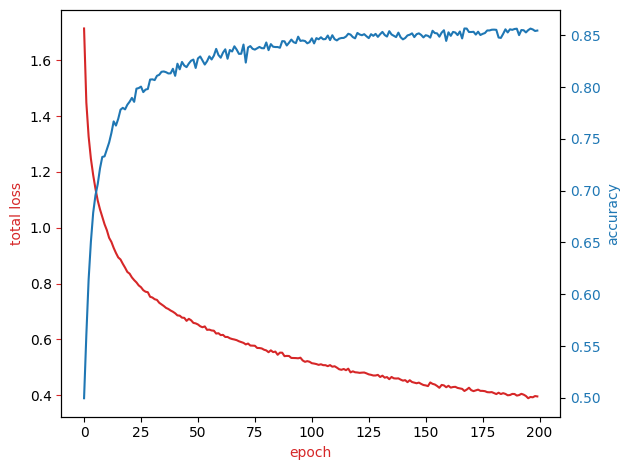

In [ ]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(train_cost_listv5, color = color)
ax1.set_xlabel('epoch', color = color)
ax1.set_ylabel('total loss', color = color)
ax1.tick_params(axis = 'y', color = color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color = color)
ax2.plot(accuracy_list_normalv5, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)
fig.tight_layout()

### Print training and validation loss

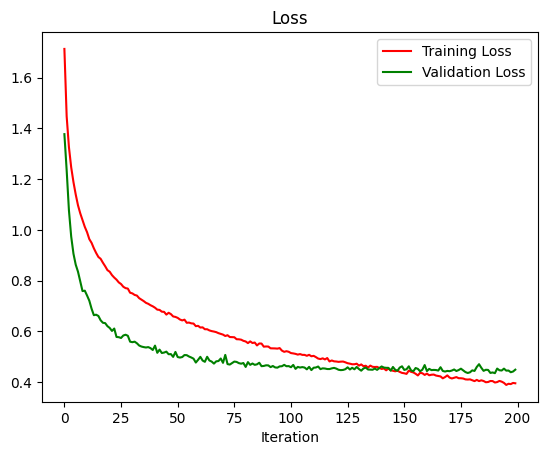

In [ ]:
plt.plot(train_cost_listv5, 'r', label = 'Training Loss')
plt.plot(val_cost_listv5, 'g', label = 'Validation Loss')
plt.xlabel('Iteration')
plt.title("Loss")
plt.legend()

### Error Analysis: Printing Confusion Matrix & Classification Report

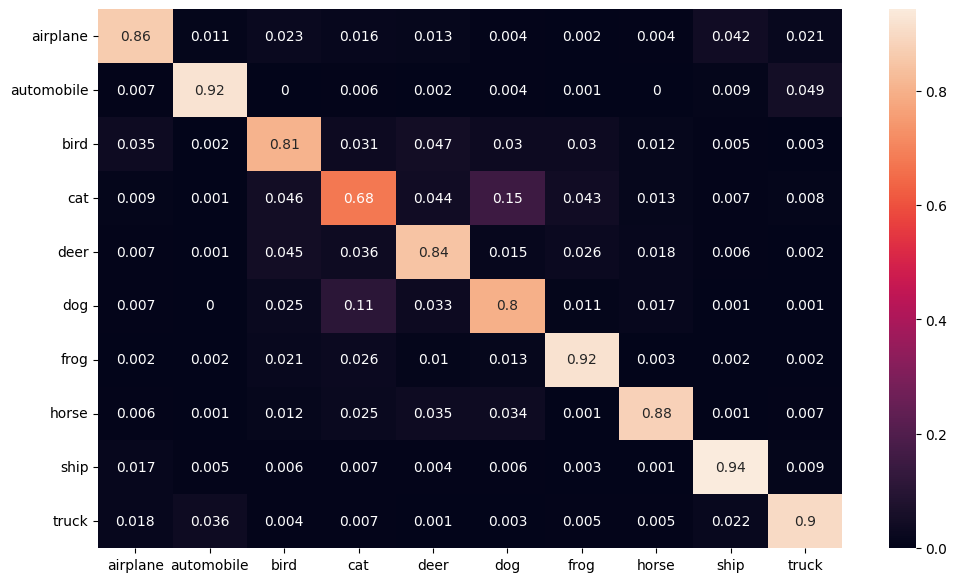

In [ ]:
y_pred = []
y_true = []

# Iterate over test data
for x, y in torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 1):
    # Print('iter val', i)
    x = x.to(cuda_device)
    y = y.to(cuda_device)
    z = model_mmtv5(x)
    _, yhat = torch.max(z, 1)
    pred = yhat.data.cpu().numpy()
    y_pred.extend(pred) # Save Prediction

    labels = y.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix) * 10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12, 7))
sn.heatmap(df_cm, annot = True)
plt.savefig('output.png')

## Plot the mis-classified samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4496627..1.9320949].


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


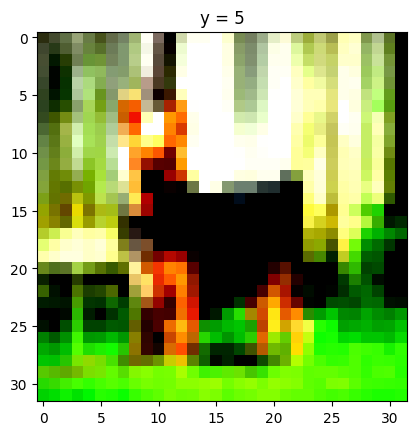

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8229808..1.9854631].


yhat:  tensor([4], device='cuda:0')
Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


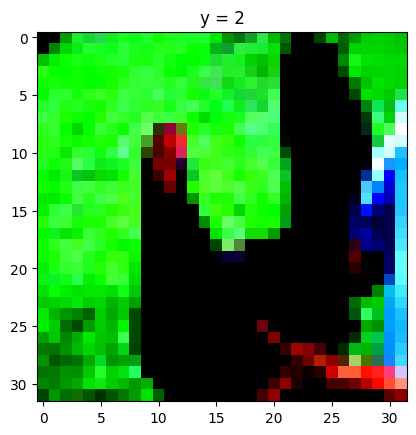

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9894737..1.985621].


yhat:  tensor([4], device='cuda:0')
Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


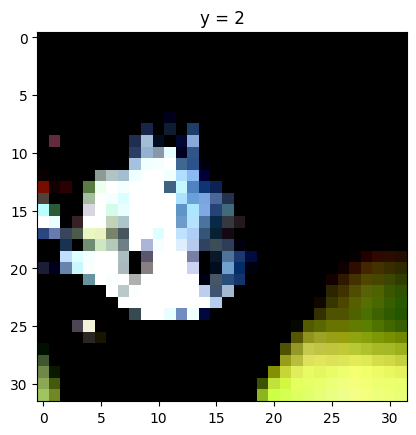

yhat:  tensor([1], device='cuda:0')


In [ ]:
count = 0
i = 0
for x, y in torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 1):
    # print('iter val', i)
    x = x.to(cuda_device)
    y = y.to(cuda_device)
    z = model_mmtv5(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
        show_data(validation_dataset[i])
        plt.show()
        print("yhat: ", yhat)
        count += 1
    if count >= 3:
        break
    i += 1

## Printing how our model performs on the first 20 images

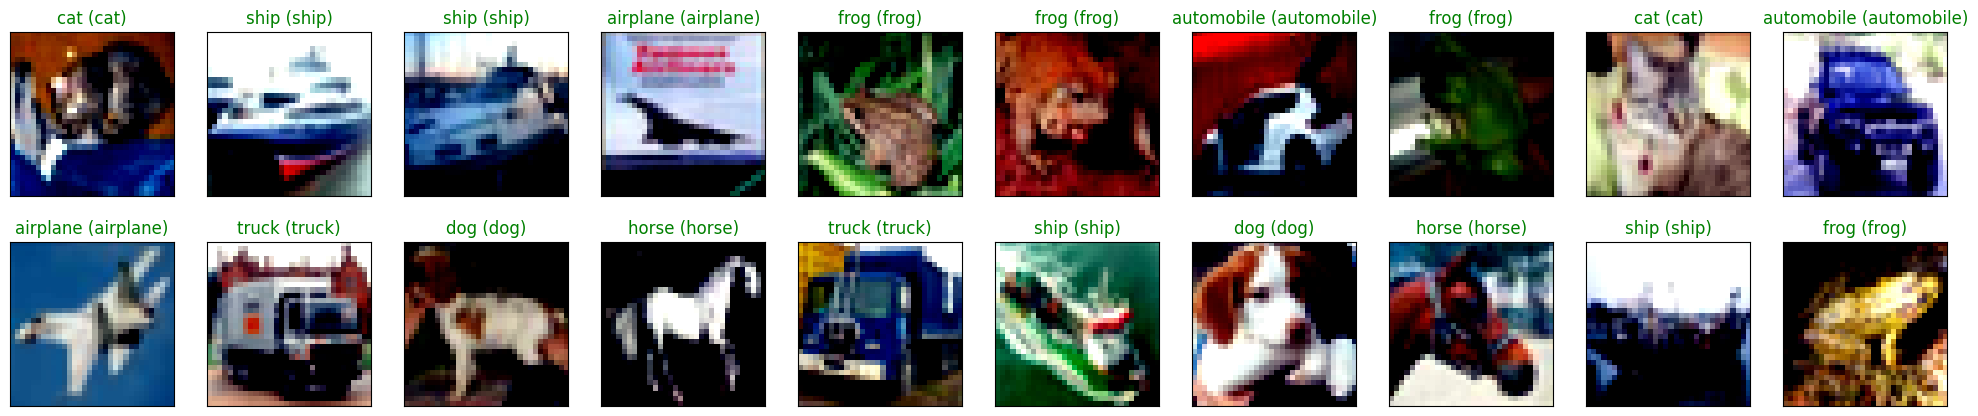

In [ ]:
data_iterable = iter(validation_loader)
images, labels = next(data_iterable)
images = images.to(cuda_device)
labels = labels.to(cuda_device)
output = model_mmtv5(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 5))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

## Performance on Hold-Out Set
#### Randomly test our model performance on random image taken from internet and see how our model performs on totally unseen data

### Example 1

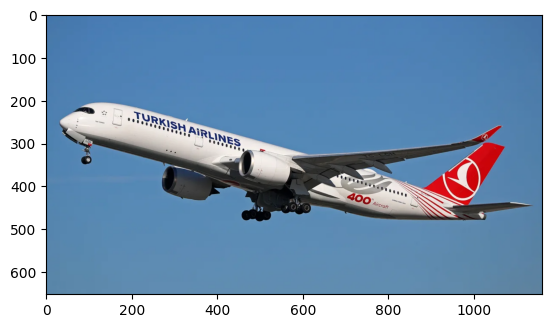

In [ ]:
url = 'https://media.cnn.com/api/v1/images/stellar/prod/gettyimages-1798755354.jpg?c=16x9&q=h_653,w_1160,c_fill/f_webp'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

Prediction my Model: airplane


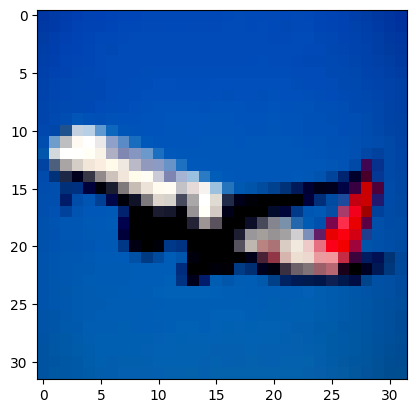

In [ ]:
# Convert holdout image to testing format
img = composed_test(img)
plt.imshow(im_convert(img))

image = img.to(cuda_device).unsqueeze(0)
output = model_mmtv5(image)
_, pred = torch.max(output, 1)
print("Prediction my Model:", (classes[pred.item()]))

### Example 2

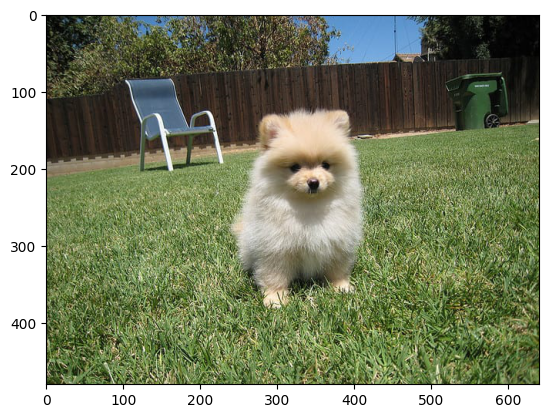

In [ ]:
url = 'https://iheartdogs.com/wp-content/uploads/2015/01/2726776480_203d247fc3_z-1.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

Prediction my Model: dog


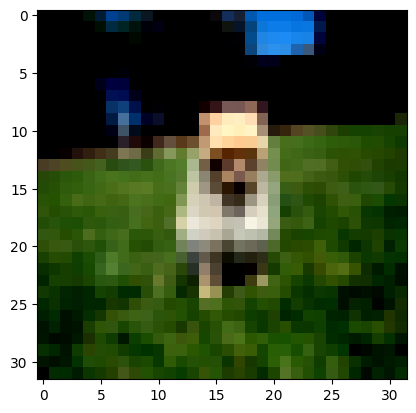

In [ ]:
# Convert holdout image to testing format
img = composed_test(img)
plt.imshow(im_convert(img))
image = img.to(cuda_device).unsqueeze(0)
output = model_mmtv5(image)
_, pred = torch.max(output, 1)
print("Prediction my Model:", (classes[pred.item()]))